In [88]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.optim import SGD, Adam
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


torch.manual_seed(42)

## DATA
- [ml-latest-small](https://grouplens.org/datasets/movielens/latest/) 

In [89]:
raw_data = pd.read_csv("ratings.csv")
item_data = pd.read_csv("movies.csv")

'''
movie id의 값  : [     1      3      6 ... 160836 163937 163981]
movie id의 개수 : 9724
{0:1}, {1:3}, ... , {9723:163981} 이런 형태로 id를 idx로 맵핑해준 데이터로 변환해서 사용
최종 추천 결과를 출력할 때는, idx를 id로 맵핑한 결과를 보여주도록 함

user id의 경우 [1,2,..., 609, 610], 개수는 610
idx로 쓰려면 전체에 1을 빼주면 되지만, 편의를 위해 movie id처럼 맵핑해서 사용
{0:1}, {1:2}, ... , {609:610}
'''
item2idx, idx2item = {}, {}
user2idx, idx2user = {}, {}
id2title = {}

for idx, user_id in enumerate(np.unique(raw_data["userId"])):
    user2idx[user_id] = idx
    idx2user[idx] = user_id
for idx, item_id in enumerate(np.unique(raw_data["movieId"])):
    item2idx[item_id] = idx
    idx2item[idx] = item_id

# movieId - title mapping, 학습에 사용X, 후에 결과 출력에 사용하기 위함
for i in range(item_data.shape[0]):
    item_id = item_data.movieId[i]
    id2title[item_id] = item_data.title[i]

# make index data
index_data = raw_data.copy()
index_data["userId"] = raw_data["userId"].apply(lambda idx:user2idx[idx])
index_data["movieId"] = raw_data["movieId"].apply(lambda idx:item2idx[idx])

n_user = np.unique(raw_data["userId"]).shape[0]
n_item = np.unique(raw_data["movieId"]).shape[0]

In [90]:
index_data[["userId", "movieId"]]

,userId,movieId
0,0,0
1,0,2
2,0,5
3,0,43
4,0,46
...,...,...
100831,609,9416
100832,609,9443
100833,609,9444
100834,609,9445


In [91]:

class MovieLensDataset(Dataset):
    def __init__(self, data: pd.DataFrame, Binclf: bool = False):
        self.data = data
        self.Binclf = Binclf
        self.items = torch.tensor(self.data[["userId", "movieId"]].values)
        self.targets = torch.tensor(self.data.rating.values)
        self.field_dims = torch.max(self.items, axis=0).values + torch.tensor([1])
        self.user_field_idx = torch.tensor([0])
        self.item_field_idx = torch.tensor([0])

        if self.Binclf:
            self.__target2Bin()

    def __len__(self) -> int:
        return self.targets.shape[0]

    def __getitem__(self, idx: int) -> tuple[torch.tensor, torch.tensor]:
        return self.items[idx], self.targets[idx]

    def __target2Bin(self):
        self.targets[self.targets <= 3] = 0
        self.targets[self.targets > 3] = 1

## Model 

- Linear term     
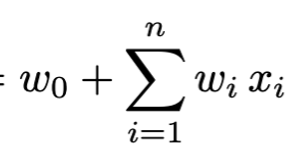

In [92]:
class FeatureLinear(nn.Module):
    def __init__(self, field_dims, output_dim=1):
        super().__init__()
        self.fc = nn.Embedding(sum(field_dims), output_dim) # (n_user+n_item, output_dim)
        self.bias = nn.Parameter(torch.zeros((output_dim,))) # global bias
        self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.int_) # [0, n_user]

    def forward(self, x):
        '''
        x : long tensor of size (batch, num_fields)
            user, item
        row   .    .
        row   .    .
        '''
        x = x + x.new_tensor(self.offsets).unsqueeze(0) # item의 id에 유저의 수만큼 더해줌 103을 맞추기 위함
        return torch.sum(self.fc(x), dim=1) + self.bias 

- FeatureEmbedding : V

In [93]:
class FeatureEmbedding(nn.Module):
    def __init__(self, field_dims, embed_dim=16):
        super().__init__()
        self.embedding = nn.Embedding(sum(field_dims), embed_dim) # (n_user+n_item, output_dim), 유저가 100명일 때, 아이템 3번의 위치는 103이 됨
        self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.int_) # [0, n_user]
        nn.init.xavier_uniform_(self.embedding.weight.data)

    def forward(self, x):
        '''
        x : long tensor of size (batch, num_fields)
            user, item
        row
        row
        '''
        x = x + x.new_tensor(self.offsets).unsqueeze(0) # item의 id에 유저의 수만큼 더해줌 103을 맞추기 위함
        return self.embedding(x)

- ix   
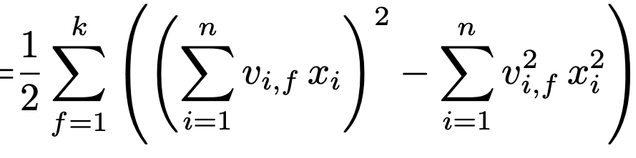
- model eq   
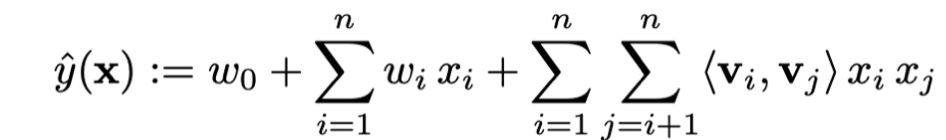

In [94]:
class FM(nn.Module):
    def __init__(self, field_dims, embed_dim=16, clf=False):
        super().__init__()
        self.linear = FeatureLinear(field_dims)
        self.embedding = FeatureEmbedding(field_dims, embed_dim)
        self.clf = clf

    def forward(self, x):
        '''
        x : float tensor of size (batch, num_fields)
            user, item
        row
        row
        '''
        square_of_sum = torch.sum(self.embedding(x),dim=1)**2
        sum_of_square = torch.sum(self.embedding(x)**2, dim=1)
        ix = 0.5*(torch.sum(square_of_sum - sum_of_square, dim=1, keepdim=True))
        x = self.linear(x) + ix
        if self.clf:
            return torch.sigmoid(x.squeeze(1))
        return x.squeeze(1)


## trainer

In [95]:
def train(model, optimizer, dataloader, criterion, device):
    model.train()
    total_loss = 0

    for fields, target in tqdm(dataloader):

        fields = fields.to(device)
        target = target.to(device)

        out = model(fields).double()
        loss = criterion(out, target)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(dataloader)


def eval(model, dataloader, device, criterion):
    model.eval()
    preds = []
    total_loss = 0

    with torch.no_grad():
        for fields, target in dataloader:
            fields = fields.to(device)
            target = target.to(device)

            out = model(fields).double()
            total_loss += criterion(out, target)

            preds.extend(out)

    return torch.tensor(preds), total_loss / len(dataloader)

In [96]:
def RMSE(actual, pred):
    mse = nn.MSELoss()
    eps = 1e-6
    return torch.sqrt(mse(pred, actual)+eps)

## Main
- Reg case

In [109]:
# Hyper parameters
embed_dim = 70
batch_size = 1024
epochs = 50
lr = 0.01
weight_decay = 1e-3
device = 'cpu'
optimizer = "Adam"
optims = {"SGD": SGD, "Adam": Adam}
Binclf = False

In [110]:
dataset = MovieLensDataset(index_data, Binclf)
train_len = int(len(dataset)*0.8)
valid_len = int(len(dataset)*0.1)
test_len = len(dataset) - train_len - valid_len

train_dataset, valid_dataset, test_dataset = random_split(dataset, (train_len, valid_len, test_len))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [111]:
field_dims = dataset.field_dims

model = FM(field_dims, embed_dim, Binclf)
criterion = nn.BCELoss() if Binclf else RMSE
metric = roc_auc_score if Binclf else RMSE

In [112]:
best_loss = 1e5
best_epoch = 1
all_train_loss = []
all_valid_loss = []

for epoch in range(1, epochs+1):
    train_loss = train(model, optims[optimizer](params=model.parameters(), lr=lr, weight_decay=weight_decay), train_dataloader, criterion, device)
    pred, valid_loss = eval(model, valid_dataloader, device, criterion)

    print(f'EPOCH : {epoch} | Train Loss : {train_loss} | Valid Loss : {valid_loss}')
    all_train_loss.append(train_loss)
    all_valid_loss.append(valid_loss)

    if valid_loss < best_loss:
        best_loss = valid_loss
        best_epoch = epoch

print(f'BEST EPOCH : {best_epoch} | Best Valid Loss : {best_loss}')

100%|██████████| 79/79 [00:00<00:00, 109.93it/s]


EPOCH : 1 | Train Loss : 3.1971148896739923 | Valid Loss : 2.289734736683214


100%|██████████| 79/79 [00:00<00:00, 113.17it/s]


EPOCH : 2 | Train Loss : 1.870429766073294 | Valid Loss : 1.4721145504643052


100%|██████████| 79/79 [00:00<00:00, 108.80it/s]


EPOCH : 3 | Train Loss : 1.247230337917132 | Valid Loss : 1.0495088410202047


100%|██████████| 79/79 [00:00<00:00, 114.84it/s]


EPOCH : 4 | Train Loss : 0.9756471650009998 | Valid Loss : 0.9290054772596298


100%|██████████| 79/79 [00:00<00:00, 133.66it/s]


EPOCH : 5 | Train Loss : 0.9229852638815825 | Valid Loss : 0.9156621599369185


100%|██████████| 79/79 [00:00<00:00, 120.24it/s]


EPOCH : 6 | Train Loss : 0.9154321896566084 | Valid Loss : 0.9130708190909653


100%|██████████| 79/79 [00:00<00:00, 119.97it/s]


EPOCH : 7 | Train Loss : 0.9132781676205141 | Valid Loss : 0.9122515405106938


100%|██████████| 79/79 [00:00<00:00, 134.61it/s]


EPOCH : 8 | Train Loss : 0.9124693484241412 | Valid Loss : 0.9119458523761346


100%|██████████| 79/79 [00:00<00:00, 136.66it/s]


EPOCH : 9 | Train Loss : 0.9121009913850452 | Valid Loss : 0.9118024092568235


100%|██████████| 79/79 [00:00<00:00, 107.64it/s]


EPOCH : 10 | Train Loss : 0.911923166222128 | Valid Loss : 0.9117259197448042


100%|██████████| 79/79 [00:00<00:00, 110.56it/s]


EPOCH : 11 | Train Loss : 0.9118271570290355 | Valid Loss : 0.9116963556302429


100%|██████████| 79/79 [00:00<00:00, 117.70it/s]


EPOCH : 12 | Train Loss : 0.9117766849263619 | Valid Loss : 0.9116746178927956


100%|██████████| 79/79 [00:00<00:00, 131.63it/s]


EPOCH : 13 | Train Loss : 0.9117534159509818 | Valid Loss : 0.9116701933307271


100%|██████████| 79/79 [00:00<00:00, 125.78it/s]


EPOCH : 14 | Train Loss : 0.911734620212322 | Valid Loss : 0.9116580437634203


100%|██████████| 79/79 [00:00<00:00, 112.96it/s]


EPOCH : 15 | Train Loss : 0.911729132266595 | Valid Loss : 0.9116578320076204


100%|██████████| 79/79 [00:00<00:00, 119.41it/s]


EPOCH : 16 | Train Loss : 0.9117236518646615 | Valid Loss : 0.9116568531912304


100%|██████████| 79/79 [00:00<00:00, 114.74it/s]


EPOCH : 17 | Train Loss : 0.9117203043390825 | Valid Loss : 0.9116548220209184


100%|██████████| 79/79 [00:00<00:00, 111.18it/s]


EPOCH : 18 | Train Loss : 0.9117208654028016 | Valid Loss : 0.9116543048454838


100%|██████████| 79/79 [00:00<00:00, 116.45it/s]


EPOCH : 19 | Train Loss : 0.9117182194156235 | Valid Loss : 0.9116586045795589


100%|██████████| 79/79 [00:00<00:00, 131.96it/s]


EPOCH : 20 | Train Loss : 0.9117196190076926 | Valid Loss : 0.9116535881575805


100%|██████████| 79/79 [00:00<00:00, 127.32it/s]


EPOCH : 21 | Train Loss : 0.911718197956484 | Valid Loss : 0.9116557196804864


100%|██████████| 79/79 [00:00<00:00, 128.95it/s]


EPOCH : 22 | Train Loss : 0.9117179979387783 | Valid Loss : 0.911656206092149


100%|██████████| 79/79 [00:00<00:00, 133.10it/s]


EPOCH : 23 | Train Loss : 0.9117189585098578 | Valid Loss : 0.9116561011095963


100%|██████████| 79/79 [00:00<00:00, 113.96it/s]


EPOCH : 24 | Train Loss : 0.9117186215099018 | Valid Loss : 0.9116539602566727


100%|██████████| 79/79 [00:00<00:00, 114.76it/s]


EPOCH : 25 | Train Loss : 0.9117172731776872 | Valid Loss : 0.9116575527707417


100%|██████████| 79/79 [00:00<00:00, 115.13it/s]


EPOCH : 26 | Train Loss : 0.9117165402136841 | Valid Loss : 0.9116519848993642


100%|██████████| 79/79 [00:00<00:00, 121.99it/s]


EPOCH : 27 | Train Loss : 0.9117203366561063 | Valid Loss : 0.91165752035555


100%|██████████| 79/79 [00:00<00:00, 129.58it/s]


EPOCH : 28 | Train Loss : 0.911714744588838 | Valid Loss : 0.9116557330410103


100%|██████████| 79/79 [00:00<00:00, 105.58it/s]


EPOCH : 29 | Train Loss : 0.9117214319534531 | Valid Loss : 0.9116555267032069


100%|██████████| 79/79 [00:00<00:00, 110.68it/s]


EPOCH : 30 | Train Loss : 0.911716201742977 | Valid Loss : 0.9116516224460733


100%|██████████| 79/79 [00:00<00:00, 97.59it/s] 


EPOCH : 31 | Train Loss : 0.9117198752527501 | Valid Loss : 0.9116583846791958


100%|██████████| 79/79 [00:00<00:00, 116.00it/s]


EPOCH : 32 | Train Loss : 0.9117158314249818 | Valid Loss : 0.9116520916962386


100%|██████████| 79/79 [00:00<00:00, 120.40it/s]


EPOCH : 33 | Train Loss : 0.9117214957915898 | Valid Loss : 0.9116558177703824


100%|██████████| 79/79 [00:00<00:00, 125.41it/s]


EPOCH : 34 | Train Loss : 0.9117160708768747 | Valid Loss : 0.9116540463241776


100%|██████████| 79/79 [00:00<00:00, 129.22it/s]


EPOCH : 35 | Train Loss : 0.9117206588397554 | Valid Loss : 0.9116570189426734


100%|██████████| 79/79 [00:00<00:00, 132.22it/s]


EPOCH : 36 | Train Loss : 0.9117162610114071 | Valid Loss : 0.9116530388577413


100%|██████████| 79/79 [00:00<00:00, 108.89it/s]


EPOCH : 37 | Train Loss : 0.9117190597610209 | Valid Loss : 0.9116583948787994


100%|██████████| 79/79 [00:00<00:00, 115.69it/s]


EPOCH : 38 | Train Loss : 0.91171626991566 | Valid Loss : 0.9116511992752686


100%|██████████| 79/79 [00:00<00:00, 118.56it/s]


EPOCH : 39 | Train Loss : 0.9117187844019476 | Valid Loss : 0.9116547641978716


100%|██████████| 79/79 [00:00<00:00, 133.39it/s]


EPOCH : 40 | Train Loss : 0.911717735444399 | Valid Loss : 0.911656473857958


100%|██████████| 79/79 [00:00<00:00, 135.73it/s]


EPOCH : 41 | Train Loss : 0.9117179305647546 | Valid Loss : 0.9116548346619945


100%|██████████| 79/79 [00:00<00:00, 105.56it/s]


EPOCH : 42 | Train Loss : 0.9117193996437875 | Valid Loss : 0.9116517548833938


100%|██████████| 79/79 [00:00<00:00, 111.58it/s]


EPOCH : 43 | Train Loss : 0.9117171724779356 | Valid Loss : 0.9116569356947014


100%|██████████| 79/79 [00:00<00:00, 113.00it/s]


EPOCH : 44 | Train Loss : 0.9117195885492984 | Valid Loss : 0.9116547535924667


100%|██████████| 79/79 [00:00<00:00, 111.99it/s]


EPOCH : 45 | Train Loss : 0.9117178229923575 | Valid Loss : 0.9116543140508993


100%|██████████| 79/79 [00:00<00:00, 130.90it/s]


EPOCH : 46 | Train Loss : 0.9117207600060252 | Valid Loss : 0.9116552702704583


100%|██████████| 79/79 [00:00<00:00, 120.68it/s]


EPOCH : 47 | Train Loss : 0.9117179627883019 | Valid Loss : 0.9116560260995221


100%|██████████| 79/79 [00:00<00:00, 134.68it/s]


EPOCH : 48 | Train Loss : 0.911718883491646 | Valid Loss : 0.911652896943874


100%|██████████| 79/79 [00:00<00:00, 135.40it/s]


EPOCH : 49 | Train Loss : 0.9117194903157773 | Valid Loss : 0.9116575599680162


100%|██████████| 79/79 [00:00<00:00, 117.31it/s]


EPOCH : 50 | Train Loss : 0.9117191415975974 | Valid Loss : 0.9116540846712125
BEST EPOCH : 38 | Best Valid Loss : 0.9116511992752686


In [115]:
pred, _ = eval(model, test_dataloader, device, criterion)
target = dataset.targets[test_dataset.indices]
print(f'test score : {metric(target,pred)}')
print(target, pred)


test score : 0.9176460758922429
tensor([4.0000, 4.0000, 3.0000,  ..., 4.0000, 3.0000, 3.5000],
       dtype=torch.float64) tensor([4.1085, 3.8275, 3.9296,  ..., 3.7911, 2.8514, 3.5996],
       dtype=torch.float64)


In [116]:
print(min(pred))
print(max(pred))

tensor(2.0331, dtype=torch.float64)
tensor(4.8848, dtype=torch.float64)


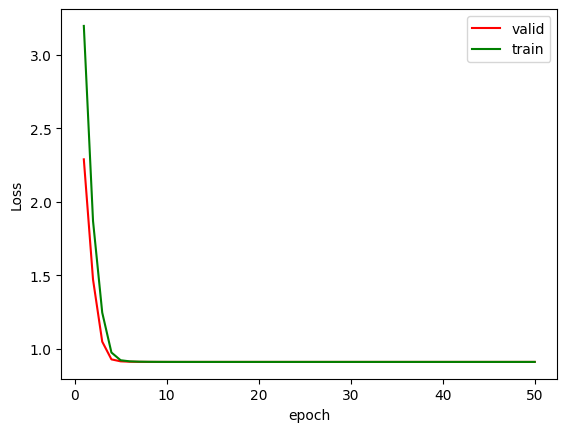

In [117]:
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.plot(range(1,epochs+1), all_valid_loss, color = "red", label='valid') 
plt.plot(range(1,epochs+1), all_train_loss, color = "green", label='train')
plt.legend()

- Binary clf case

In [118]:
# Hyper parameters
embed_dim = 70
batch_size = 1024
epochs = 50
lr = 0.001
weight_decay = 1e-3
device = 'cpu'
optimizer = "Adam"
optims = {"SGD": SGD, "Adam": Adam}
Binclf = True

dataset = MovieLensDataset(index_data, Binclf)
train_len = int(len(dataset)*0.8)
valid_len = int(len(dataset)*0.1)
test_len = len(dataset) - train_len - valid_len

train_dataset, valid_dataset, test_dataset = random_split(dataset, (train_len, valid_len, test_len))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

field_dims = dataset.field_dims

model = FM(field_dims, embed_dim, Binclf)
criterion = nn.BCELoss() if Binclf else RMSE
metric = roc_auc_score if Binclf else RMSE

best_loss = 1e5
best_epoch = 1
all_train_loss = []
all_valid_loss = []

for epoch in range(1, epochs+1):
    train_loss = train(model, optims[optimizer](params=model.parameters(), lr=lr, weight_decay=weight_decay), train_dataloader, criterion, device)
    pred, valid_loss = eval(model, valid_dataloader, device, criterion)

    print(f'EPOCH : {epoch} | Train Loss : {train_loss} | Valid Loss : {valid_loss}')
    all_train_loss.append(train_loss)
    all_valid_loss.append(valid_loss)

    if valid_loss < best_loss:
        best_loss = valid_loss
        best_epoch = epoch

print(f'BEST EPOCH : {best_epoch} | Best Valid Loss : {best_loss}')

100%|██████████| 79/79 [00:00<00:00, 108.93it/s]


EPOCH : 1 | Train Loss : 0.7972575235292129 | Valid Loss : 0.7234601097667649


100%|██████████| 79/79 [00:00<00:00, 127.32it/s]


EPOCH : 2 | Train Loss : 0.6724533390576515 | Valid Loss : 0.6470293353435475


100%|██████████| 79/79 [00:00<00:00, 105.46it/s]


EPOCH : 3 | Train Loss : 0.622797688278041 | Valid Loss : 0.6178511760151907


100%|██████████| 79/79 [00:00<00:00, 111.34it/s]


EPOCH : 4 | Train Loss : 0.6056253162860044 | Valid Loss : 0.6090264485000259


100%|██████████| 79/79 [00:00<00:00, 114.95it/s]


EPOCH : 5 | Train Loss : 0.6006616940169136 | Valid Loss : 0.6070204682022149


100%|██████████| 79/79 [00:00<00:00, 114.48it/s]


EPOCH : 6 | Train Loss : 0.5995242836242997 | Valid Loss : 0.6067227191578101


100%|██████████| 79/79 [00:00<00:00, 116.22it/s]


EPOCH : 7 | Train Loss : 0.5993412918030943 | Valid Loss : 0.6066851661546879


100%|██████████| 79/79 [00:00<00:00, 116.37it/s]


EPOCH : 8 | Train Loss : 0.5992993388885383 | Valid Loss : 0.6066725702807764


100%|██████████| 79/79 [00:00<00:00, 112.05it/s]


EPOCH : 9 | Train Loss : 0.5992834142170547 | Valid Loss : 0.6066688563063984


100%|██████████| 79/79 [00:00<00:00, 115.04it/s]


EPOCH : 10 | Train Loss : 0.5992784602546718 | Valid Loss : 0.6066667425689364


100%|██████████| 79/79 [00:00<00:00, 114.11it/s]


EPOCH : 11 | Train Loss : 0.5992760782300472 | Valid Loss : 0.6066666388737981


100%|██████████| 79/79 [00:00<00:00, 130.59it/s]


EPOCH : 12 | Train Loss : 0.5992756316518182 | Valid Loss : 0.6066659447186894


100%|██████████| 79/79 [00:00<00:00, 115.48it/s]


EPOCH : 13 | Train Loss : 0.5992747923289405 | Valid Loss : 0.6066663417386691


100%|██████████| 79/79 [00:00<00:00, 114.08it/s]


EPOCH : 14 | Train Loss : 0.5992752936023072 | Valid Loss : 0.6066658423870028


100%|██████████| 79/79 [00:00<00:00, 132.52it/s]


EPOCH : 15 | Train Loss : 0.5992745790568195 | Valid Loss : 0.6066663046435279


100%|██████████| 79/79 [00:00<00:00, 130.20it/s]


EPOCH : 16 | Train Loss : 0.5992756536791404 | Valid Loss : 0.6066657935518431


100%|██████████| 79/79 [00:00<00:00, 132.85it/s]


EPOCH : 17 | Train Loss : 0.5992745452704097 | Valid Loss : 0.606666300991829


100%|██████████| 79/79 [00:00<00:00, 132.20it/s]


EPOCH : 18 | Train Loss : 0.599275316088329 | Valid Loss : 0.6066658100327059


100%|██████████| 79/79 [00:00<00:00, 127.91it/s]


EPOCH : 19 | Train Loss : 0.5992747885102164 | Valid Loss : 0.6066663225929692


100%|██████████| 79/79 [00:00<00:00, 126.98it/s]


EPOCH : 20 | Train Loss : 0.5992751081286474 | Valid Loss : 0.6066658700391038


100%|██████████| 79/79 [00:00<00:00, 131.46it/s]


EPOCH : 21 | Train Loss : 0.5992748313669822 | Valid Loss : 0.6066662541936949


100%|██████████| 79/79 [00:00<00:00, 115.86it/s]


EPOCH : 22 | Train Loss : 0.5992755584905122 | Valid Loss : 0.6066658022700098


100%|██████████| 79/79 [00:00<00:00, 117.58it/s]


EPOCH : 23 | Train Loss : 0.5992747268763486 | Valid Loss : 0.6066662653334681


100%|██████████| 79/79 [00:00<00:00, 125.67it/s]


EPOCH : 24 | Train Loss : 0.5992748084822507 | Valid Loss : 0.6066657948049043


100%|██████████| 79/79 [00:00<00:00, 134.40it/s]


EPOCH : 25 | Train Loss : 0.5992748686694145 | Valid Loss : 0.6066662965377655


100%|██████████| 79/79 [00:00<00:00, 131.69it/s]


EPOCH : 26 | Train Loss : 0.5992747065705395 | Valid Loss : 0.6066657919285714


100%|██████████| 79/79 [00:00<00:00, 131.65it/s]


EPOCH : 27 | Train Loss : 0.5992752212128832 | Valid Loss : 0.6066663142777664


100%|██████████| 79/79 [00:00<00:00, 116.95it/s]


EPOCH : 28 | Train Loss : 0.5992751654664642 | Valid Loss : 0.6066657892176732


100%|██████████| 79/79 [00:00<00:00, 117.41it/s]


EPOCH : 29 | Train Loss : 0.599274692179917 | Valid Loss : 0.6066662958722208


100%|██████████| 79/79 [00:00<00:00, 110.85it/s]


EPOCH : 30 | Train Loss : 0.599275119866826 | Valid Loss : 0.6066657987915873


100%|██████████| 79/79 [00:00<00:00, 133.28it/s]


EPOCH : 31 | Train Loss : 0.5992748611671722 | Valid Loss : 0.6066662806796804


100%|██████████| 79/79 [00:00<00:00, 132.76it/s]


EPOCH : 32 | Train Loss : 0.5992757876755986 | Valid Loss : 0.6066658171986135


100%|██████████| 79/79 [00:00<00:00, 111.48it/s]


EPOCH : 33 | Train Loss : 0.5992747487177087 | Valid Loss : 0.6066662780615966


100%|██████████| 79/79 [00:00<00:00, 115.10it/s]


EPOCH : 34 | Train Loss : 0.5992750587407056 | Valid Loss : 0.6066658075341135


100%|██████████| 79/79 [00:00<00:00, 105.36it/s]


EPOCH : 35 | Train Loss : 0.5992747110976412 | Valid Loss : 0.6066663044060803


100%|██████████| 79/79 [00:00<00:00, 124.18it/s]


EPOCH : 36 | Train Loss : 0.5992754176464029 | Valid Loss : 0.6066657958791296


100%|██████████| 79/79 [00:00<00:00, 119.54it/s]


EPOCH : 37 | Train Loss : 0.5992748323608509 | Valid Loss : 0.6066662668996673


100%|██████████| 79/79 [00:00<00:00, 112.94it/s]


EPOCH : 38 | Train Loss : 0.5992752266142127 | Valid Loss : 0.6066658634558043


100%|██████████| 79/79 [00:00<00:00, 103.66it/s]


EPOCH : 39 | Train Loss : 0.599274606815017 | Valid Loss : 0.6066662921191274


100%|██████████| 79/79 [00:00<00:00, 106.87it/s]


EPOCH : 40 | Train Loss : 0.5992750497534155 | Valid Loss : 0.6066658140762998


100%|██████████| 79/79 [00:00<00:00, 114.19it/s]


EPOCH : 41 | Train Loss : 0.5992743354579605 | Valid Loss : 0.6066662881780003


100%|██████████| 79/79 [00:00<00:00, 118.01it/s]


EPOCH : 42 | Train Loss : 0.5992753977999509 | Valid Loss : 0.6066658005557669


100%|██████████| 79/79 [00:00<00:00, 115.41it/s]


EPOCH : 43 | Train Loss : 0.5992745576182745 | Valid Loss : 0.606666312674242


100%|██████████| 79/79 [00:00<00:00, 111.36it/s]


EPOCH : 44 | Train Loss : 0.599275274829273 | Valid Loss : 0.6066658292505939


100%|██████████| 79/79 [00:00<00:00, 117.50it/s]


EPOCH : 45 | Train Loss : 0.5992747137402022 | Valid Loss : 0.6066662618200125


100%|██████████| 79/79 [00:00<00:00, 115.70it/s]


EPOCH : 46 | Train Loss : 0.5992750886409745 | Valid Loss : 0.6066657825556945


100%|██████████| 79/79 [00:00<00:00, 130.82it/s]


EPOCH : 47 | Train Loss : 0.5992743038567953 | Valid Loss : 0.6066663116569143


100%|██████████| 79/79 [00:00<00:00, 132.17it/s]


EPOCH : 48 | Train Loss : 0.5992752975979441 | Valid Loss : 0.6066657758625259


100%|██████████| 79/79 [00:00<00:00, 129.66it/s]


EPOCH : 49 | Train Loss : 0.5992746437136193 | Valid Loss : 0.6066663164776169


100%|██████████| 79/79 [00:00<00:00, 128.42it/s]


EPOCH : 50 | Train Loss : 0.5992752608329671 | Valid Loss : 0.6066658201008029
BEST EPOCH : 48 | Best Valid Loss : 0.6066657758625259


test score : 0.7420730646148765
tensor([1., 0., 1.,  ..., 1., 1., 1.], dtype=torch.float64) tensor([0.7497, 0.6436, 0.5805,  ..., 0.7040, 0.7205, 0.6158],
       dtype=torch.float64)


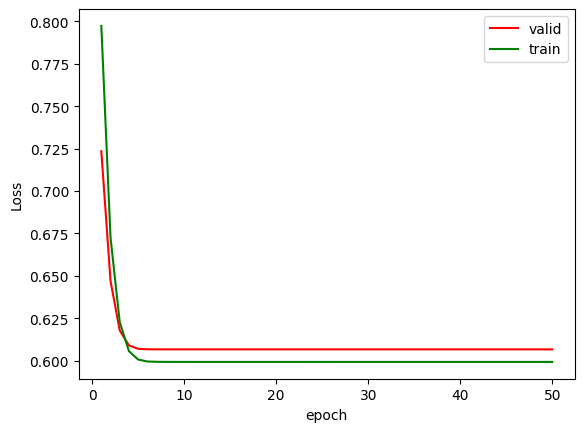

In [119]:
pred, _ = eval(model, test_dataloader, device, criterion)
target = dataset.targets[test_dataset.indices]
print(f'test score : {metric(target,pred)}')
print(target, pred)

plt.xlabel("epoch")
plt.ylabel("Loss")
plt.plot(range(1,epochs+1), all_valid_loss, color = "red", label='valid') 
plt.plot(range(1,epochs+1), all_train_loss, color = "green", label='train')
plt.legend()
